# Frame

## 하이퍼 파라미터 : 1. 모듈

In [55]:
#--Tensorflow Framework + SKLEARN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
import numpy as np

#--check program performance
import time
import psutil

#--data visualization
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import sys

#--for manipulating image datas
import json
import os
import cv2
from PIL import Image 
import random

## 하이퍼 파라미터 : 2. 데이터셋 위치 설정

In [3]:
ROOT_DATA_FOLDER = '../../../dataset/deepfake_detection'

## 하이퍼 파라미터 : 3. 데이터셋 설정

In [4]:
TRAINABLE_FLOWER_DATA = []
LABEL = []

## 하이퍼 파라미터 : 4. 학습 설정

In [5]:
BATCH_SIZE=128
EPOCHS=10

## 데이터셋 살펴보기

In [20]:
deepfake_folder_list = os.listdir(ROOT_DATA_FOLDER)
ext_list = []
print("deepfake_detection 폴더 안의 Data 갯수 : ", len(deepfake_folder_list))

deepfake_detection 폴더 안의 Data 갯수 :  403


- deepfake_detection 폴더 안에 있는 모든 Data가 .mp4가 아닐 수도 있다.
- deepfake_detection 폴더 안에 확장명이 없는 폴더도 존재할 수도 있으므로 무조건 확장명이 있다고 생각하면서 프로그래밍하는 것보단 조건문을 추가한다.

In [24]:
[ext_list.append(file.split('.')[1]) for file in deepfake_folder_list if len(file.split('.'))==2 and file.split('.')[1] not in ext_list]
ext_list

['mp4', 'json']

In [28]:
[print(f"확장자 '{ext_name}'을 가진 파일의 수 : {len([file for file in deepfake_folder_list if file.endswith(ext_name)])}") for ext_name in ext_list]
print("deepfake_detection 폴더 안의 Data 갯수 : ", len(deepfake_folder_list))

확장자 'mp4'을 가진 파일의 수 : 400
확장자 'json'을 가진 파일의 수 : 1
deepfake_detection 폴더 안의 Data 갯수 :  403


- 403개 중에 2개는 파일이 아닌 폴더이며 학습용 영상은 400개로 이루어져 있고, json 파일은 1개이다.

자! 이제 json 파일 내용을 확인해보자.

In [40]:
json_file_name = [file for file in deepfake_folder_list if file.endswith('.json') ][0]
json_file_name

'metadata.json'

In [46]:
pd.read_json(os.path.join(ROOT_DATA_FOLDER, json_file_name))

,aagfhgtpmv.mp4,aapnvogymq.mp4,abarnvbtwb.mp4,abofeumbvv.mp4,abqwwspghj.mp4,acifjvzvpm.mp4,acqfdwsrhi.mp4,acxnxvbsxk.mp4,acxwigylke.mp4,aczrgyricp.mp4,...,esnntzzajv.mp4,esxrvsgpvb.mp4,esyhwdfnxs.mp4,esyrimvzsa.mp4,etdcqxabww.mp4,etejaapnxh.mp4,etmcruaihe.mp4,etohcvnzbj.mp4,eudeqjhdfd.mp4,eukvucdetx.mp4
label,FAKE,FAKE,REAL,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,...,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,REAL,FAKE
split,train,train,train,train,train,train,train,train,train,train,...,train,train,train,train,train,train,train,train,train,train
original,vudstovrck.mp4,jdubbvfswz.mp4,None,atvmxvwyns.mp4,qzimuostzz.mp4,kbvibjhfzo.mp4,ccfoszqabv.mp4,fjlyaizcwc.mp4,ffcwhpnpuw.mp4,slwkmefgde.mp4,...,ybetenmsye.mp4,gomwfvijiv.mp4,qeumxirsme.mp4,qzklcjjxdq.mp4,gipbyjfxfp.mp4,wtreibcmgm.mp4,afoovlsmtx.mp4,bdnaqemxmr.mp4,None,gjypopglvi.mp4


In [53]:
metadata = os.path.join(ROOT_DATA_FOLDER, json_file_name)
df = pd.read_json(metadata)
df.T

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4
...,...,...,...
etejaapnxh.mp4,FAKE,train,wtreibcmgm.mp4
etmcruaihe.mp4,FAKE,train,afoovlsmtx.mp4
etohcvnzbj.mp4,FAKE,train,bdnaqemxmr.mp4
eudeqjhdfd.mp4,REAL,train,None


In [54]:
df.T.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


 - metadata.json의 내용을 확인한 결과 video이름에 대해 deepfake영상인지 아닌지 정답을 알려준다.
 - 그리고 만일 deepfake영상이라면 어떤 원본을 이용해서 deepfake를 적용했는지 original이라는 Key에 나타나있다.
 - split 컬럼의 데이터들은 모두 train인지 확인해보자

In [76]:
def getJsonValueFromMetadata(key_name):
    with open(metadata) as json_file:
        json_data = json.load(json_file)
        print(type(json_data)) # dictionary 형태로 받아온다.
        json_data_value = [value for _, value in json_data.items()] # key를 제외하고 value만 불러온다."{'label': 'FAKE', 'split': 'train', 'original': 'vudstovrck.mp4'}"
        return [item[key_name] for item in json_data_value]

In [78]:
json_split_values = getJsonValueFromMetadata('split')
print("['split']에 해당하는 value의 갯수 :", len(json_split_values))
print("'train'값이 아닌 value의 갯수:", len([name for name in json_split_values if name != 'train']))

<class 'dict'>
['split']에 해당하는 value의 갯수 : 400
'train'값이 아닌 value의 갯수: 0


 - 결과 : train 값밖에 없다. 이 컬럼 값으로 Real, Fake로 나눌 수는 없다.
 - 그럼 어떤 기준으로 train과 validation 셋을 나눌까?
 - original 컬럼을 분석해보자

In [89]:
json_original_values = getJsonValueFromMetadata('original')
none_values = [f]
video_values = 

<class 'dict'>


['vudstovrck.mp4',
 'jdubbvfswz.mp4',
 None,
 'atvmxvwyns.mp4',
 'qzimuostzz.mp4',
 'kbvibjhfzo.mp4',
 'ccfoszqabv.mp4',
 'fjlyaizcwc.mp4',
 'ffcwhpnpuw.mp4',
 'slwkmefgde.mp4',
 'fysyrqfguw.mp4',
 'qjlhemtkxk.mp4',
 'dlpoieqvfb.mp4',
 None,
 'qzimuostzz.mp4',
 'proiippuup.mp4',
 'gxembgiarp.mp4',
 None,
 'iufotyxgzb.mp4',
 'aytzyidmgs.mp4',
 None,
 'dkuayagnmc.mp4',
 'jomvcqqars.mp4',
 'sunqwnmlkx.mp4',
 None,
 'ygdgwyqyut.mp4',
 None,
 'bzythlfnhq.mp4',
 'lyvlnqduqg.mp4',
 'yxyhvdlrgk.mp4',
 'swedbyuehz.mp4',
 'xlbnmndmku.mp4',
 'meawmsgiti.mp4',
 'ppdpgwyjgm.mp4',
 'fewcljwqkr.mp4',
 'cppdvdejkc.mp4',
 'tqhbgzfwsf.mp4',
 'meawmsgiti.mp4',
 'vcxckqbaya.mp4',
 'xobhsemxmv.mp4',
 'xwcggrygwl.mp4',
 'fysyrqfguw.mp4',
 'xxsxktyvzt.mp4',
 None,
 'bulkxhhknf.mp4',
 'edyncaijwx.mp4',
 'jkddywriuf.mp4',
 'uonshkejav.mp4',
 'xngpzquyhs.mp4',
 'fjlyaizcwc.mp4',
 'meawmsgiti.mp4',
 'inkqxytzyu.mp4',
 None,
 'znjupdqnwo.mp4',
 'jepguaulgf.mp4',
 'dzyuwjkjui.mp4',
 'upgerjvcjb.mp4',
 None,
 None,

## 폴더 및 파일 구성
 - 이미지들이 많아서 용량이 크다. 즉, 메모리에 한번에 올릴 수는 없다.
 - 그러므로 데이터들을 나누어서 학습시켜야 한다.

In [17]:
print(f"REAL 영상 수 : {len(REAL_DATASET_LIST)}, 경로 : {REAL_DATA_PATH}")
print(f"FAKE 영상 수 : {len(FAKE_DATASET_LIST)}, 경로 : {FAKE_DATA_PATH}")

REAL 영상 수 : 46858, 경로 : ../../../dataset/train_sample_videos/real
FAKE 영상 수 : 265658, 경로 : ../../../dataset/train_sample_videos/fake


In [20]:
isExistOtherExt = False
for file_set in [os.listdir(os.path.join(ROOT_DATA_FOLDER, classification)) for classification in binary_classes]:
    for file in file_set:
        if not file.endswith(".png"):
            isExistOtherExt = True
            print(file)
            
if isExistOtherExt:
    print("확장자 .png를 제외한 다른 확장자가 존재합니다.")
else:
    print("모든 파일이 .png 확장자로 구성되어 있습니다.")

모든 파일이 .png 확장자로 구성되어 있습니다.


In [27]:
real_data_name = [ img_name for img_name in os.listdir(REAL_DATA_PATH) ]
print("Real Data File Name List : ")
for name in real_data_name[:10]:
    print(name)
print('=============================')
fake_data_name = [ img_name for img_name in os.listdir(FAKE_DATA_PATH) ]
print("Fake Data File Name List : ")
for name in fake_data_name[:10]:
    print(name)

Real Data File Name List : 
ctfmwebpxh_4.png
cfayaairkq_7.png
llagpqxcma_7.png
cuwkygiyim_3.png
gqpbgirzpc_1.png
ufoipgblmn_3.png
nmqnkwxwhi_8.png
lhpkjgtikn_4.png
wbpcawlkxt_7.png
klcomxhdbf_6.png
Fake Data File Name List : 
rrluavsnpt_7.png
urcxgvwykl_0.png
yxvxcckbuq_8.png
agotmizucf_6.png
grblswgisv_2.png
lvnnkpddsi_8.png
qfpbijvpau_1.png
zuwmkkdncq_1.png
psgeptbhlk_1.png
jeckydypxe_2.png


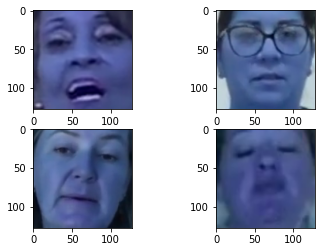

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


In [34]:
real_sample1 = os.path.join(REAL_DATA_PATH, real_data_name[10])
real_sample2 = os.path.join(REAL_DATA_PATH, real_data_name[20])
fake_sample1 = os.path.join(FAKE_DATA_PATH, fake_data_name[30])
fake_sample2 = os.path.join(FAKE_DATA_PATH, fake_data_name[40])

real_img_example1 = cv2.imread(real_sample1)
real_img_example2 = cv2.imread(real_sample2)
fake_img_example1 = cv2.imread(fake_sample1)
fake_img_example2 = cv2.imread(fake_sample2)

plt.subplot(2,2,1)
plt.imshow(real_img_example1)
plt.subplot(2,2,2)
plt.imshow(real_img_example2)
plt.subplot(2,2,3)
plt.imshow(fake_img_example1)
plt.subplot(2,2,4)
plt.imshow(fake_img_example2)
plt.show()

print(real_img_example1.shape)
print(real_img_example2.shape)
print(fake_img_example1.shape)
print(fake_img_example2.shape)

 - 영상데이터에서 얼굴부분을 추출하여 이미지로 저장할 떄 이미 128x128로 resize작업이 완료 되었단 점을 볼 수 있다.
 - 그러므로 resize 작업은 필요없다.

## 유틸리티 정의 : 1. 데이터 전처리 클래스
 - REAL 데이터셋 리스트와 FAKE 데이터셋 라벨링 후 합치기
 - 데이터셋이 크므로 Generator를 사용해 변수 할당을 줄여 메모리를 효율적으로 사용한다

In [ ]:
# 라벨링을 해주는 Generator
class Deepfake_Preprocessor:
    """
    author : RHIE MINHYUNG
    describe: 라벨링된 딥페이크 이미지셋 부여 0-fake 1-real
    [usage]
      #> datasets = Deepfake_Preprocessor()
      #> = datasets.load_data()
    """
    
    def __init__(self):
        
        self.cnt_real = 0
        self.cnt_fake = 0
        
        print("[Deepfake_Preprocessor 생성을 시작합니다...]")
        self.real_data_len = len(REAL_DATASET_LIST)
        self.fake_data_len = len(FAKE_DATASET_LIST)
        #--이미지 데이터 불러오고 list로 바꿔주기
        real_data = [self.show_process(REAL_DATA_PATH, img, data_type="real") for img in REAL_DATASET_LIST]
        print("\n......REAL 데이터 완료")
        fake_data = [self.show_process(FAKE_DATA_PATH, img, data_type="fake") for img in FAKE_DATASET_LIST]
        print("\n......FAKE 데이터 완료")
        print("[진행중1/5]이미지 데이터 불러오고 list로 바꿔주기")
        
        #--Fake=0, REAL=1 라벨을 부여해주는 제너레이터 생성
        labeled_real_gen = self.real_data_labelling(real_data)
        labeled_fake_gen = self.fake_data_labelling(fake_data)
        print("[진행중2/5]Fake=0, REAL=1 라벨을 부여해주는 제너레이터 생성")
    
        #--제너레이터 실행
        labeled_real_data = list(labeled_real_gen)
        labeled_fake_data = list(labeled_fake_gen)
        print("[진행중3/5]제너레이터 실행")
        
        #--라벨링된 REAL과 FAKE를 합친후 랜덤으로 섞기
        labeled_data = labeled_real_data + labeled_fake_data
        random.shuffle(labeled_data)
        print("[진행중4/5]라벨링된 REAL과 FAKE를 합친후 랜덤으로 섞기")
        
        #--numpy로 casting
        self.datasets = np.array(labeled_data)
        print("[완료5/5] datasets 구성: ", self.datasets.shape)
        
    def load_data(self):
        #Normalization
        X = self.datasets
        Y = to_categorical(Y, 2)

        #Reshape
        X = X.reshape(-1, 128, 128, 3)

        #Train-Test split
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
    
    def real_data_labelling(self, real_data):
        for img_array in real_data:
            labeled_real_set = (img_array, 1)
            yield labeled_real_set

    def fake_data_labelling(self, fake_data):
        for img_array in fake_data:
            labeled_fake_set = (img_array, 0)
            yield labeled_fake_set
    
    def show_process(self, path, filename, data_type=None):
        if(data_type == "real"):
            sys.stdout.write("\r"+"["+str(self.cnt_real)+" / "+str(self.real_data_len)+"]")
            self.cnt_real += 1
        elif(data_type == "fake"):
            sys.stdout.write("\r"+"["+str(self.cnt_fake)+" / "+str(self.fake_data_len)+"]")
            self.cnt_fake += 1
        return img_to_array(load_img(os.path.join(path, filename))) / 255.0

## 데이터셋 준비 ( Preprocess ) 
 - REAL 데이터셋 리스트와 FAKE 데이터셋 라벨링 후 합치기
 - 데이터셋이 크므로 Generator를 사용해 변수 할당을 줄여메모리를 효율적으로 사용한다

In [4]:
# 메모리 사용을 체크해주는 객체 process 생성
process = psutil.Process(os.getpid())

# 라벨링 실행전 메모리 상태 체크
before_time = time.clock()
mem_before = process.memory_info().rss / 1024 / 1024


datasets = Deepfake_Preprocessor()

# 라벨링 실행후 메모리 상태 체크
after_time = time.clock()
mem_after = process.memory_info().rss / 1024 / 1024
total_time = after_time - before_time

print('시작 전 메모리 사용량: {} MB'.format(mem_before))
print('종료 후 메모리 사용량: {} MB'.format(mem_after))
print('총 소요된 시간: {:.6f} 초'.format(total_time))

NameError: name 'Deepfake_Preprocessor' is not defined

## 데이터 전처리
 - 메모리가 부족해 이미지 전부를 로딩할 수 없음

In [1]:
cnt = 1
def show_process(path, filename, data_type=None):
    global cnt
    if(data_type == "real"):
        sys.stdout.write("\r"+"["+str(cnt)+" / "+str(len(REAL_DATASET_LIST))+"]")
        cnt += 1
    elif(data_type == "fake"):
        sys.stdout.write("\r"+"["+str(self.cnt_fake)+" / "+str(self.fake_data_len)+"]")
        self.cnt_fake += 1
    return img_to_array(load_img(os.path.join(path, filename))) / 255.0
#     return (img_to_array(load_img(os.path.join(path, filename))) / 255.0).tolist()

cnt2 = 1
def show_process2(path, filename, data_type=None):
    global cnt2
    if(data_type == "real"):
        sys.stdout.write("\r"+"["+str(cnt2)+" / "+str(len(REAL_DATASET_LIST))+"]")
        cnt2 += 1
    elif(data_type == "fake"):
        sys.stdout.write("\r"+"["+str(self.cnt_fake)+" / "+str(self.fake_data_len)+"]")
        self.cnt_fake += 1
    return img_to_array(load_img(os.path.join(path, filename))) / 255.0     
#     return (img_to_array(load_img(os.path.join(path, filename))) / 255.0).tolist()

# 메모리 사용을 체크해주는 객체 process 생성
process = psutil.Process(os.getpid())
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    print('시작 전 메모리 사용량: {} MB'.format(process.memory_info().rss / 1024 / 1024))
    arrImg = [show_process(REAL_DATA_PATH, REAL_DATASET_LIST[i], data_type="real") for i in range(10)]
    print("")
    print("완료")
#     onlyImg = [show_process2(REAL_DATA_PATH, REAL_DATASET_LIST[i], data_type="real") for i in range(int(len(REAL_DATASET_LIST)/10))]
    print("")
    print("완료")
    print('시작 후 메모리 사용량: {} MB'.format(process.memory_info().rss / 1024 / 1024))

NameError: name 'psutil' is not defined

In [25]:
def real_data_labelling(real_data):
    for img_array in real_data:
        yield img_array
X = np.array(arrImg)
aagen = real_data_labelling(X)
Y = np.array(list(aagen))
Y

array([[[[0.5058824 , 0.4862745 , 0.4745098 ],
         [0.5058824 , 0.49411765, 0.47843137],
         [0.5058824 , 0.49803922, 0.48235294],
         ...,
         [0.07450981, 0.06666667, 0.05098039],
         [0.07450981, 0.06666667, 0.05098039],
         [0.07450981, 0.06666667, 0.05098039]],

        [[0.5058824 , 0.4862745 , 0.4745098 ],
         [0.5019608 , 0.49019608, 0.4745098 ],
         [0.5019608 , 0.49411765, 0.47843137],
         ...,
         [0.07843138, 0.07058824, 0.05490196],
         [0.07843138, 0.06666667, 0.05490196],
         [0.07843138, 0.06666667, 0.05490196]],

        [[0.5019608 , 0.48235294, 0.47058824],
         [0.49803922, 0.4862745 , 0.47058824],
         [0.5019608 , 0.49411765, 0.47843137],
         ...,
         [0.09019608, 0.07450981, 0.0627451 ],
         [0.09019608, 0.07450981, 0.0627451 ],
         [0.09019608, 0.07450981, 0.0627451 ]],

        ...,

        [[0.4392157 , 0.43137255, 0.42352942],
         [0.4392157 , 0.43137255, 0.41960785]

In [26]:
Y.shape

(10, 128, 128, 3)

In [ ]:
tf.keras.preprocessing.image.ImageDataGenerator(
    REAL_DATA_PATH,
    rescale=1./255
)

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
Inception_Resnet_model = keras.models.load_model('Inception_Resnet_Model.h5')

In [ ]:
Inception_Resnet_model.summary()